In [2]:
library("plyr")
library("dplyr")
library("IDE")
library("FRK")
library("ggplot2")
library("sp")
library("spacetime")
library("STRbook")

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: 'FRK'


The following objects are masked from 'package:STRbook':

    LinePlotTheme, NOAA_df_1990


The following object is masked from 'package:stats':

    simulate




In [3]:
SIM1 <- simIDE(T = 10, nobs = 100, k_spat_invariant = 1)

'as(<ngCMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "dMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



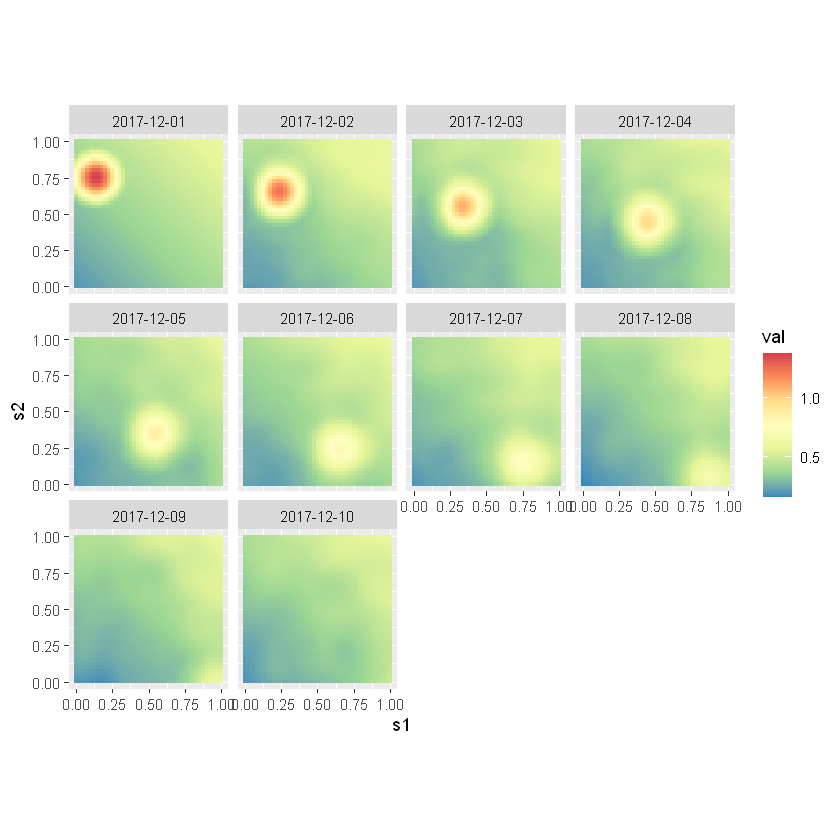

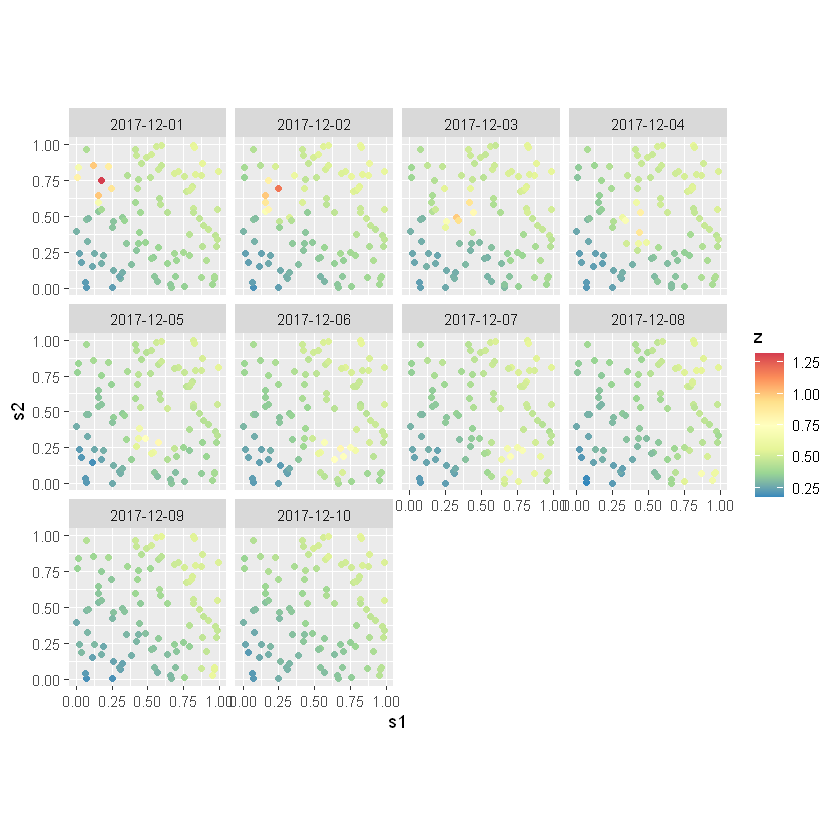

In [4]:
print(SIM1$g_truth)
print(SIM1$g_obs)

In [5]:
IDEmodel <- IDE(f = z ~ s1 + s2,
                data = SIM1$z_STIDF,
                dt = as.difftime(1, units = "days"),
                grid_size = 41)

In [6]:
data("IDE_Sim1_results", package = "STRbook")

Kernel is spatially invariant, plotting it centred on the origin.

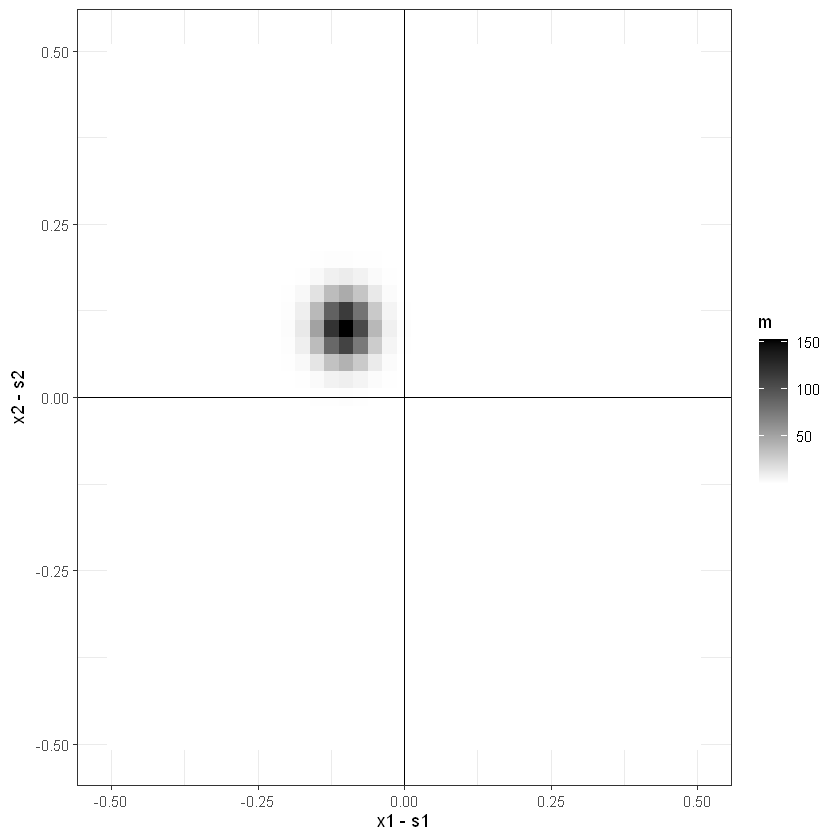

In [7]:
show_kernel(fit_results_sim1$IDEmodel)

In [8]:
fit_results_sim1$IDEmodel$get("k") %>% unlist()

par1          par2          par3          par4 
152.836345912   0.001977115  -0.101601099   0.100368743

In [9]:
coef(fit_results_sim1$IDEmodel)

Intercept        s1        s2 
0.2073442 0.1966224 0.1907062

In [10]:
abs_ev <- eigen(fit_results_sim1$IDEmodel$get("M"))$values %>%
          abs()
summary(abs_ev)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00285 0.28953 0.36604 0.33107 0.39853 0.46409 

In [11]:
ST_grid_df <- predict(fit_results_sim1$IDEmodel)

In [12]:
gpred <- ggplot(ST_grid_df) +       # Plot the predictions
  geom_tile(aes(s1, s2, fill=Ypred)) +
  facet_wrap(~t) +
  fill_scale(name = "Ypred", limits = c(-0.1, 1.4)) +
  coord_fixed(xlim=c(0, 1), ylim = c(0, 1))

gpredse <- ggplot(ST_grid_df) +     # Plot the prediction s.es
  geom_tile(aes(s1, s2, fill = Ypredse)) +
  facet_wrap(~t) +
  fill_scale(name = "Ypredse") +
  coord_fixed(xlim=c(0, 1), ylim = c(0, 1))

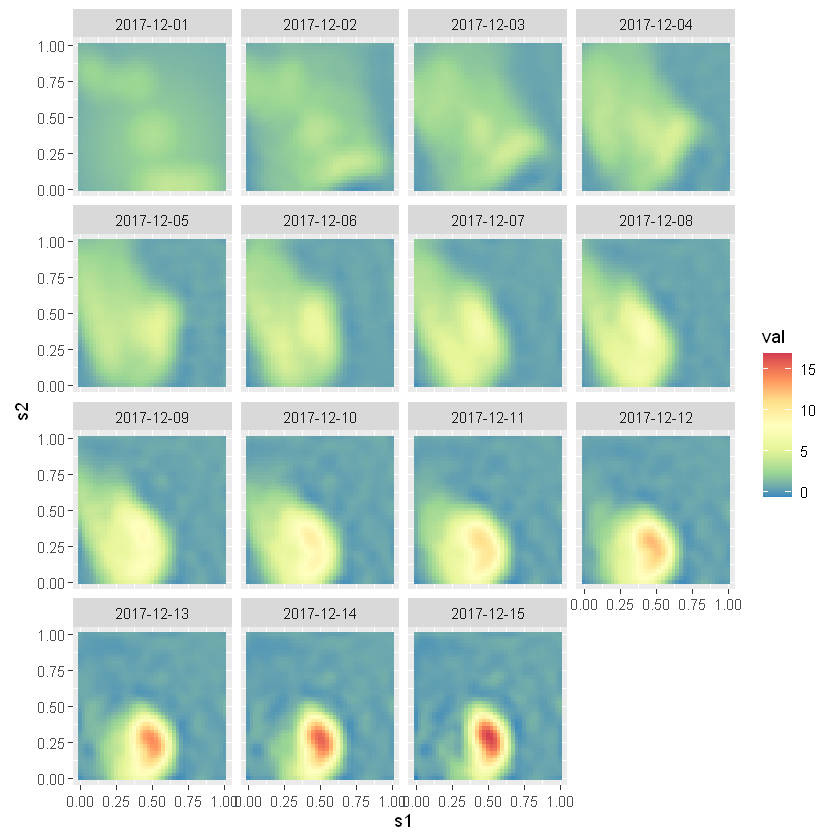

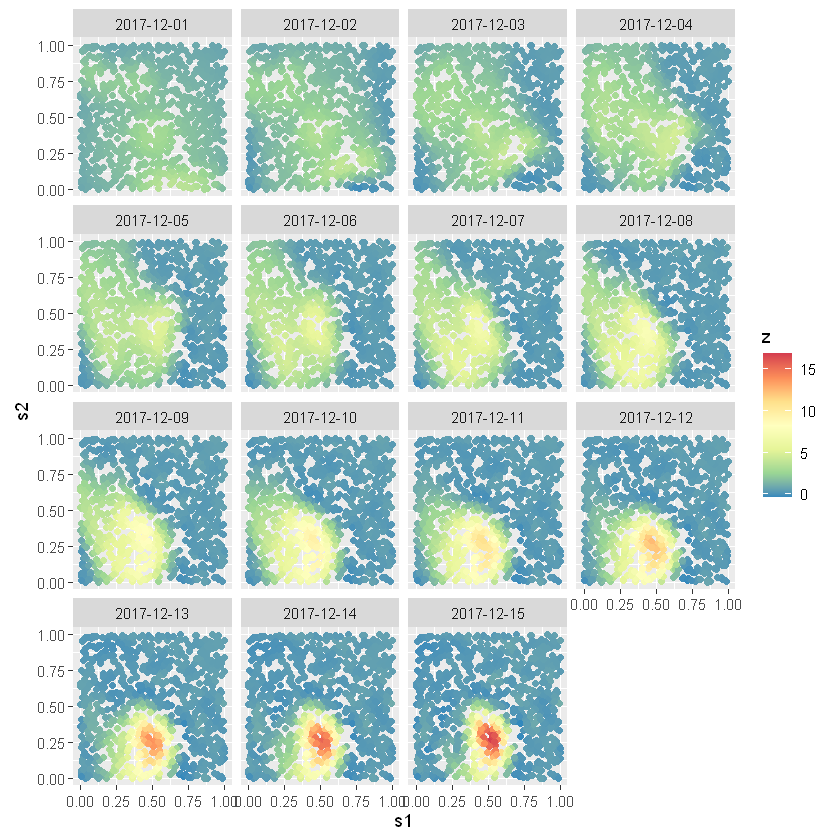

In [13]:
SIM2 <- simIDE(T = 15, nobs = 1000, k_spat_invariant = 0)

## ----results = 'hide', fig.keep = 'none'---------------------------------
print(SIM2$g_truth)
print(SIM2$g_obs)

Kernel is spatially variant, plotting displacements

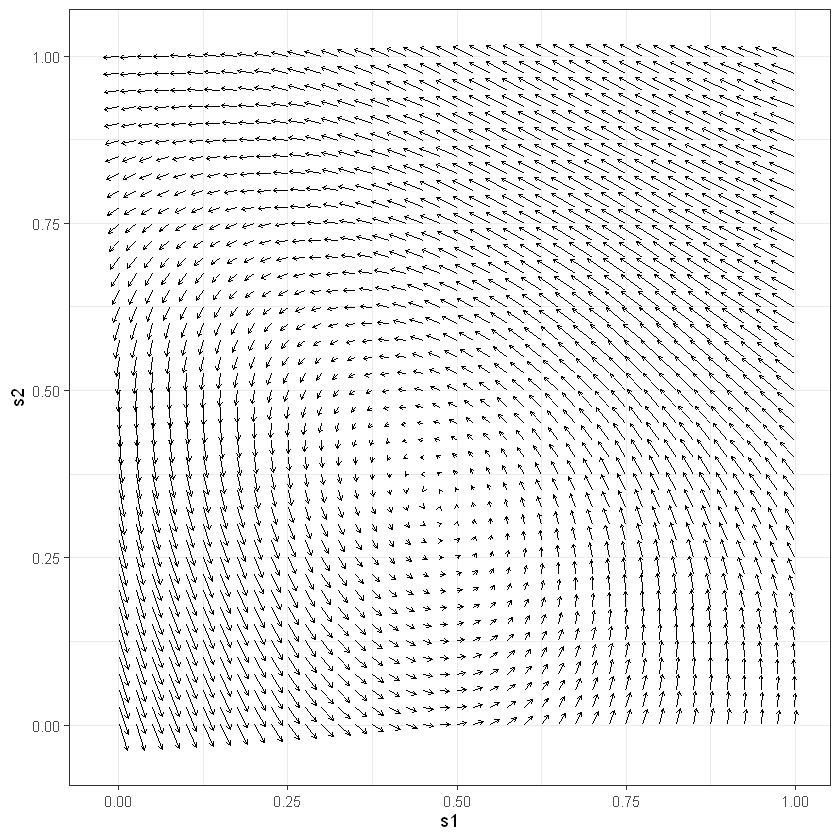

In [14]:
show_kernel(SIM2$IDEmodel, scale = 0.2)

In [15]:
mbasis_1 <- auto_basis(manifold = plane(),   # fns on the plane
                       data = SIM2$z_STIDF,  # data
                       nres = 1,             # 1 resolution
                       type = 'bisquare')

In [16]:
kernel_basis <- list(thetam1 = constant_basis(),
                     thetam2 = constant_basis(),
                     thetam3 = mbasis_1,
                     thetam4 = mbasis_1)

In [17]:
IDEmodel <- IDE(f = z ~ s1 + s2 + 1,
                data = SIM2$z_STIDF,
                dt = as.difftime(1, units = "days"),
                grid_size = 41,
                kernel_basis = kernel_basis)

In [18]:
data("IDE_Sim2_results", package = "STRbook")

Kernel is spatially variant, plotting displacements

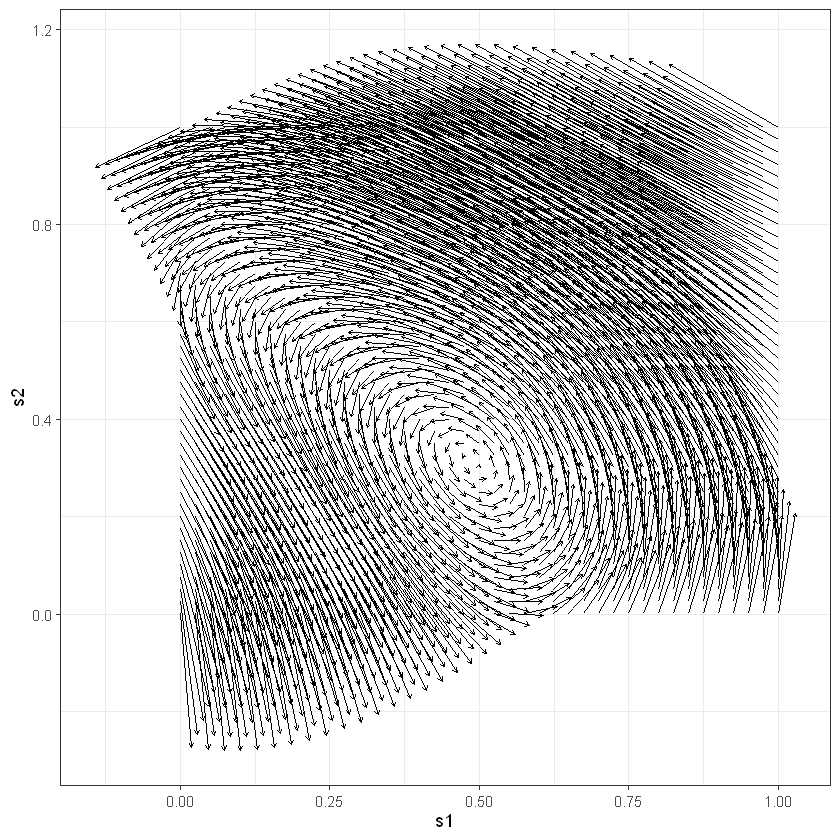

In [19]:
show_kernel(fit_results_sim2$IDEmodel)

In [20]:
K1 <- show_kernel(fit_results_sim2$IDEmodel, scale = 0.2) + ggplot2::coord_fixed()
K2 <- show_kernel(SIM2$IDEmodel, scale = 0.2) + ggplot2::coord_fixed()
g <- grid.arrange(K1, K2, ncol = 2)

Kernel is spatially variant, plotting displacementsKernel is spatially variant, plotting displacements

ERROR: Error in grid.arrange(K1, K2, ncol = 2): could not find function "grid.arrange"


In [21]:
data("radar_STIDF", package = "STRbook")

In [22]:
IDEmodel <- IDE(f = z ~ 1,
                data = radar_STIDF,
                dt = as.difftime(10, units = "mins"),
                grid_size = 41,
                forecast = 2,
                hindcast = 2)

In [23]:
data("IDE_Radar_results", package = "STRbook")

Kernel is spatially invariant, plotting it centred on the origin.

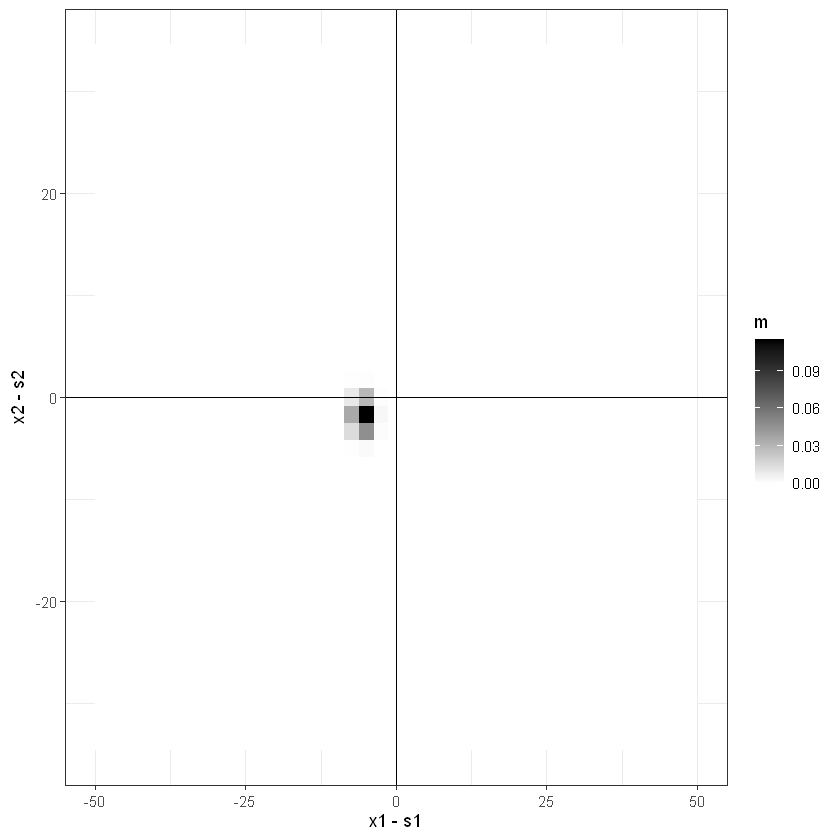

In [24]:
show_kernel(fit_results_radar$IDEmodel)

In [25]:
options(digits = 2)

In [26]:
shift_pars <- (fit_results_radar$IDEmodel$get("k") %>%
                   unlist())[3:4]
print(shift_pars)

par3 par4 
-5.5 -1.9 


In [27]:
abs_ev <- eigen(fit_results_radar$IDEmodel$get("M"))$values %>%
          abs()
summary(abs_ev)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.01    0.58    0.67    0.62    0.72    0.79 

In [28]:
ST_grid_df <- predict(fit_results_radar$IDEmodel)

In [29]:
radar_df$time <- format(radar_df$t, "%H:%M")
ST_grid_df$time <- format(ST_grid_df$t, "%H:%M")

In [30]:
radar_df <- rbind.fill(radar_df,
                       data.frame(time = c("08:05", "08:15",
                                           "10:25", "10:35")))

## Plot of data, with color scale capped to (-20, 60)
gobs <- ggplot(radar_df) +
  geom_tile(aes(s1, s2, fill = pmin(pmax(z, -20), 60))) +
  fill_scale(limits = c(-20, 60), name = "Z") +
  facet_wrap(~time) + coord_fixed() + theme_bw()

## Plot of predictions with color scale forced to (-20, 60)
gpred <- ggplot(ST_grid_df) +
  geom_tile(aes(s1, s2, fill = Ypred)) +
  facet_wrap(~time) + coord_fixed() + theme_bw() +
  fill_scale(limits = c(-20, 60), name = "Ypred")

Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_tile()`)."


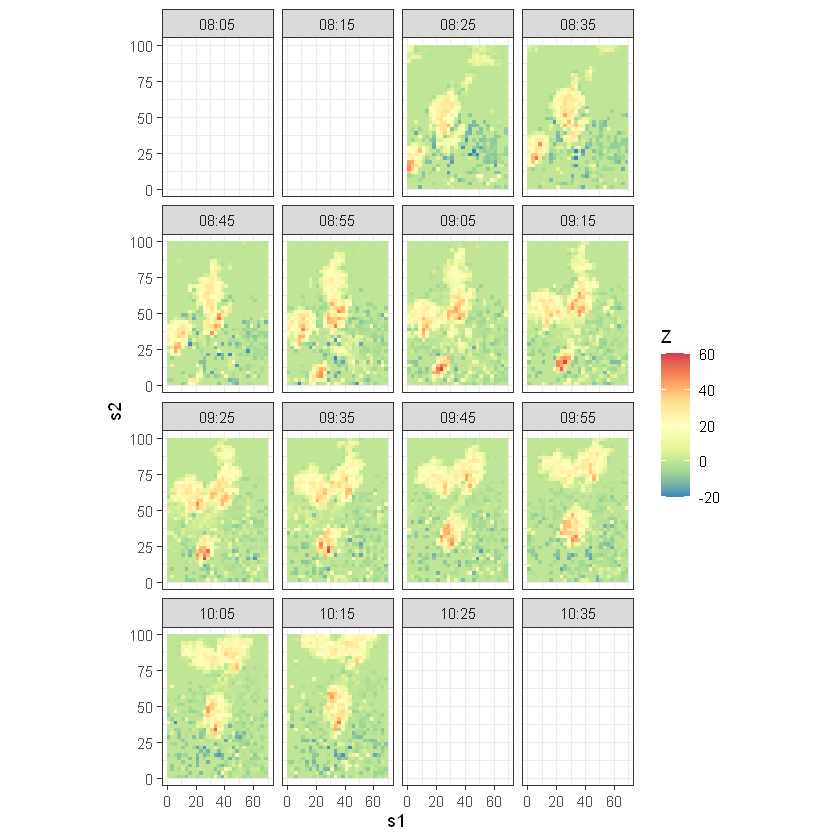

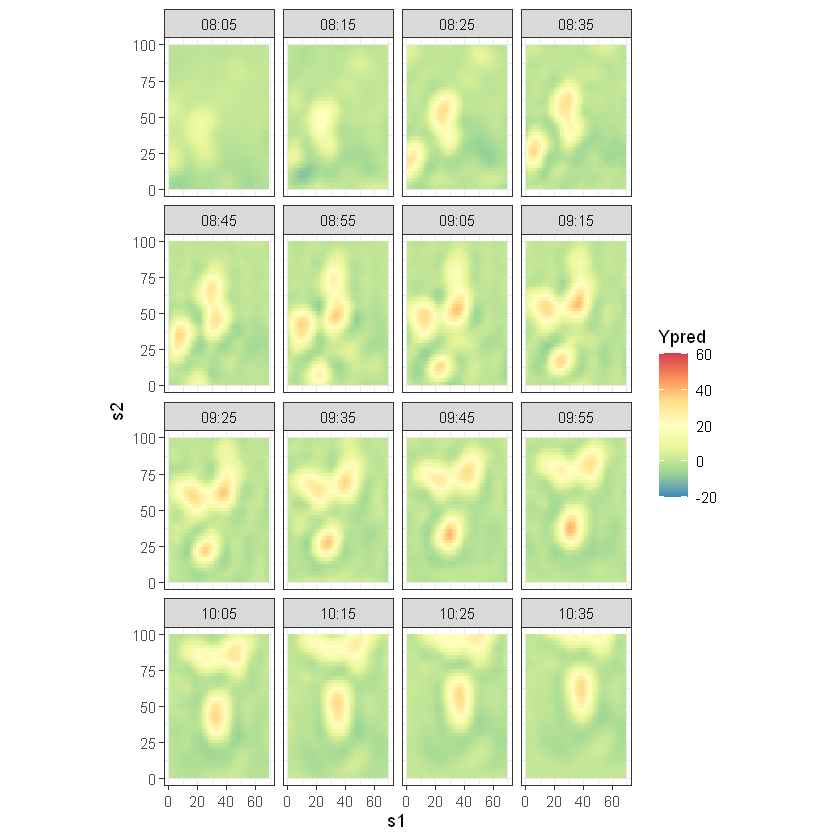

In [31]:
gobs
gpred